In [1]:
import torch
import numpy as np
from torch import Tensor
import pandas as pd

from matplotlib import rc_file
rc_file("../../matplotlibrc")

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

from labproject.metrics.MMD import *
from labproject.metrics.sliced_wasserstein import sliced_wasserstein_distance
from labproject.metrics.c2st import *
from labproject.experiments import Experiment

/home/alana/Documents/phd/code/labproject/labproject/plotting.py:13: UserWarning: Style includes a parameter, 'figure.max_open_warning', that is not related to style.  Ignoring this parameter.
  plt.style.use(STYLE_PATH)


In [27]:
dataset1 = torch.load('../../data/ddm/real_data.pt').unsqueeze(-1) 
dataset2 = torch.load('../../data/ddm/generated_data.pt').unsqueeze(-1) 

In [51]:
class Metric:
    def __init__(self, name: str, func: callable, **kwargs):
        self.name = name
        self.func = func
        self.kwargs = kwargs

    def __call__(self, x: Tensor, y: Tensor) -> Tensor:
        return self.func(x, y, **self.kwargs)


class DistComp(Experiment):
    def __init__(self, dataset1: Tensor, dataset2: Tensor, metrics: list[Metric], 
                 n_perms: int = 100, perm_size=1000, descr=""):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.metrics = metrics
        self.n_perms = n_perms
        self.perm_size = perm_size
        self.descr = descr

        columns = [metric.name for metric in metrics]
        self.results_df = pd.DataFrame(np.nan, index=range(self.n_perms), columns=columns)

    def run_experiment(self):
        for i in range(self.n_perms):
            dataset2_perm = self.dataset2[torch.randperm(len(self.dataset2))[:self.perm_size]]
            dataset1_perm = self.dataset1[torch.randperm(len(self.dataset1))[:self.perm_size]]
            for metric in self.metrics:
                self.results_df.loc[i, metric.name] = tensor(metric(dataset1_perm, dataset2_perm)).numpy()
    
    def reformat_df(self, data):
        """
        reformat the results_df to work with seaborn plot expectations.
        """
        metric = [column_name for _, row in data.iterrows() for column_name, _ in row.items()]
        split_ind = [i for i, _ in data.iterrows() for _ in range(len(data.columns))]
        distance = [value for _, row in data.iterrows() for _, value in row.items()]

        return pd.DataFrame({"metric": metric, "distance": distance, "split_ind": split_ind})
        

In [52]:

metrics = [
    Metric('wasserstein', 
           sliced_wasserstein_distance,
           num_projections=50,
           p=1),
    Metric('mmd-rbf', 
           mmd_rbf),
    Metric('c2st-knn', 
           c2st_knn,
           ),
]

experiments = [
    # DistComp( ## NOTE! datasets provided here are either conditioned/unconditioned -- doesn't happen in the pipeline
    #     dataset1, dataset1, metrics, n_perms=1, perm_size=100,
    #     descr='unconditional within-group real data'
    # ),
    # DistComp(
    #     dataset2, dataset2, metrics, n_perms=1, perm_size=100,
    #     descr='unconditional within-group generated data'
    # ),
    DistComp(
        dataset1, dataset2, metrics, n_perms=10, perm_size=100,
        descr='ddm - unconditional between-group'
    ),
]

for experiment in experiments:
    experiment.run_experiment()


/tmp/ipykernel_3661682/1962442188.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.results_df.loc[i, metric.name] = tensor(metric(dataset1_perm, dataset2_perm)).numpy()
/tmp/ipykernel_3661682/1962442188.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.results_df.loc[i, metric.name] = tensor(metric(dataset1_perm, dataset2_perm)).numpy()
/tmp/ipykernel_3661682/1962442188.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.results_df.loc[i, metric.name] = tensor(metric(dataset1_perm, dataset2_perm)).numpy()
/tmp/ipyke

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'sans-serif' not found because none of 

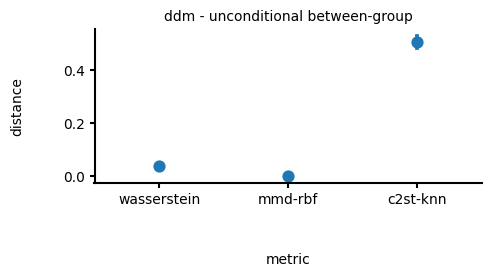

In [54]:
nm_plots = len(experiments)

fig = plt.figure(figsize=(5,2*nm_plots))
gs = gridspec.GridSpec(nm_plots,1, figure=fig, hspace=0.5)

for i, experiment in enumerate(experiments): 

    title = experiment.descr
    data = experiment.reformat_df(experiment.results_df)
    
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[i])

    ax = fig.add_subplot(gs00[:,:])

    sns.pointplot(data=data, x = "metric", y="distance", linestyle="none")
    
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.text(-0.2, 0.5, 'distance', transform=ax.transAxes, rotation='vertical',
            ha='center', va='center')

ax.text(0.5, -.5, 'metric', transform=ax.transAxes, rotation='horizontal',
            ha='center', va='center')

plt.show()
